In [54]:
using Revise

using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI
using ITensors

struct result
    M::Int
    tci::TCI.TensorCI
    ranks::Vector{Float64}
    errors::Vector{Float64}
    time::Float64
end

In [97]:
a, b = -50, 50
nquantics = 8
ndiscretization = 2^nquantics
xvals = range(a, b; length=ndiscretization)
step = div(ndiscretization, 256)

function f1(M::Int)
    f(x) = sum(exp(-abs(x) / (2 * n)) for n in 1:M)
    return f
end

function f2(M::Int)
    f(x) = sum(exp(-x^2 / (2 * n)) for n in 1:M)
    return f
end

f2 (generic function with 1 method)

In [98]:
ninit = 1
results = result[]
#additionalpivots = [
#    rand([1, 2], nquantics)
#    #[fill(2, i)..., fill(1, nquantics-i)...]
#    for i in 1:ninit
#]

for M in 1:9
    f(q) = f1(M)(xvals[quantics_to_index(q)[1]])
    firstpivot = fill(1, nquantics) # TCI.optfirstpivot(f, fill(2, nquantics))
    #additionalpivots::Vector{TCI.MultiIndex} = [rand([1, 2], nquantics) for _ in 1:2M]

    time = @elapsed tci, ranks, errors = TCI.crossinterpolate(
        Float64,
        f,
        fill(2, nquantics),
        firstpivot,
        tolerance=1e-12,
        additionalpivots=[[2, 2, fill(1, nquantics-2)...]]
    )
    push!(results, result(M, tci, ranks, errors, time))
end

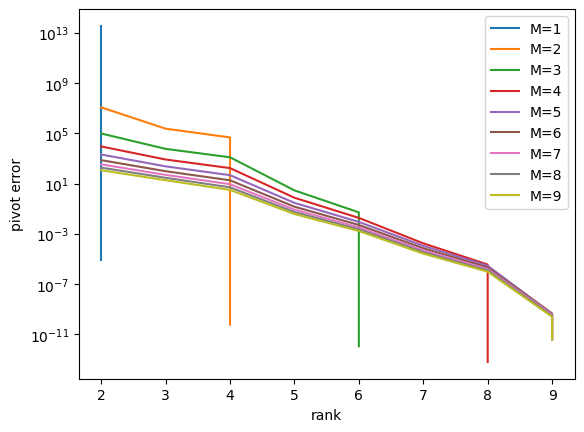

PyObject <matplotlib.legend.Legend object at 0x2b368e490>

In [99]:
for r in results
    semilogy(r.ranks, r.errors, label="M=$(r.M)")
end
xlabel("rank")
ylabel("pivot error")
legend()

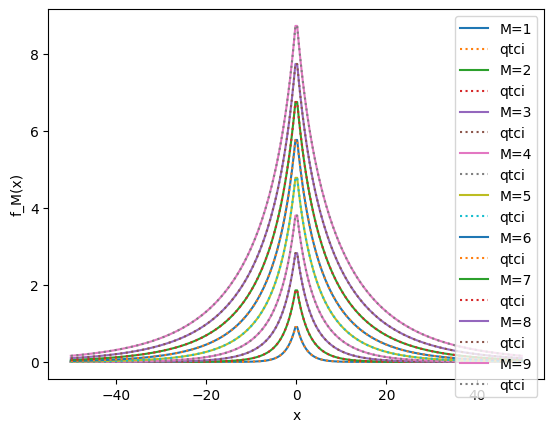

PyObject <matplotlib.legend.Legend object at 0x2b37aaeb0>

In [100]:
mpslist = [qtt_to_mps(TCI.tensortrain(r.tci)) for r in results]

for (r, mps) in zip(results, mpslist)
    tcieval = [evaluate_mps(mps, siteinds(mps), index_to_quantics(i, nquantics)) for i in 1:step:ndiscretization]
    original = [f1(r.M)(xvals[quantics_to_index(index_to_quantics(i, nquantics))[1]]) for i in 1:step:ndiscretization]
    plot(xvals[1:step:ndiscretization], original, label="M=$(r.M)")
    plot(xvals[1:step:ndiscretization], tcieval, ":", label="qtci")
end
xlabel("x")
ylabel("f_M(x)")
legend()

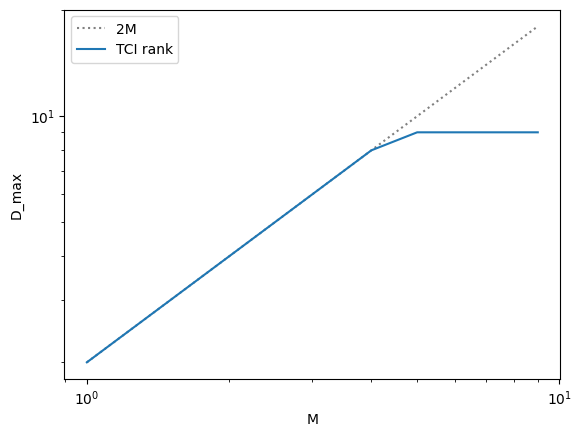

PyObject <matplotlib.legend.Legend object at 0x2b396e430>

In [101]:
Ms = [r.M for r in results]
loglog(Ms, 2 .* Ms, "gray", linestyle=":", label="2M")
loglog(Ms, [TCI.rank(r.tci) for r in results], label="TCI rank")
xlabel("M")
ylabel("D_max")
legend()

In [102]:
results = result[]
additionalpivots = [
    rand([1, 2], nquantics)
    #[fill(2, i)..., fill(1, nquantics-i)...]
    for i in 1:25
]


for M in 1:12
    f(q) = f2(M)(xvals[quantics_to_index(q)[1]] / 10)
    firstpivot = fill(1, nquantics) # TCI.optfirstpivot(f, fill(2, nquantics))
    time = @elapsed tci, ranks, errors = TCI.crossinterpolate(
        Float64,
        f,
        fill(2, nquantics),
        firstpivot,
        tolerance=1e-12,
        additionalpivots=additionalpivots
    )
    push!(results, result(M, tci, ranks, errors, time))
end

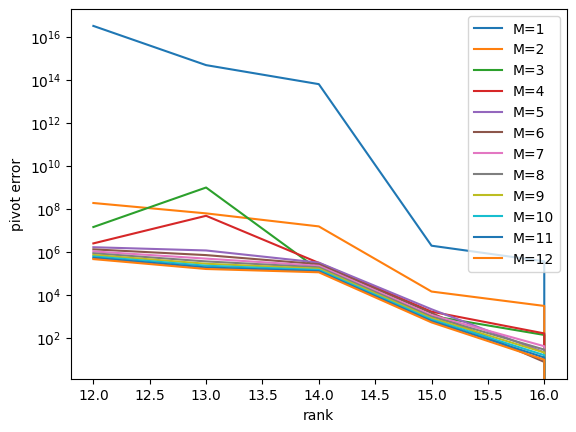

PyObject <matplotlib.legend.Legend object at 0x2b39aa130>

In [103]:
for r in results
    semilogy(r.ranks, r.errors, label="M=$(r.M)")
end
xlabel("rank")
ylabel("pivot error")
legend()

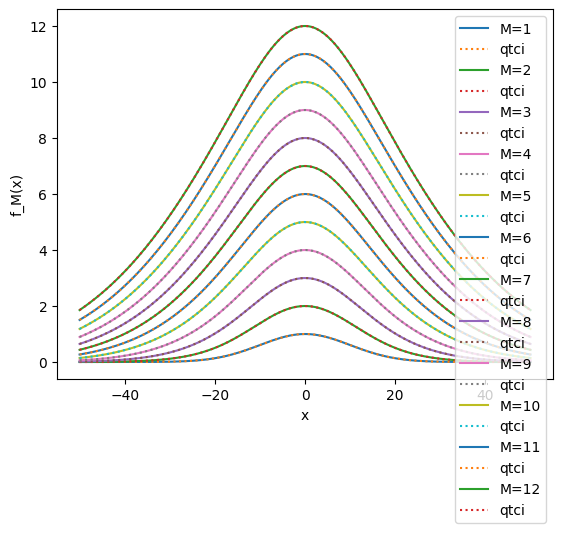

PyObject <matplotlib.legend.Legend object at 0x2b3b8dbe0>

In [104]:
mpslist = [qtt_to_mps(TCI.tensortrain(r.tci)) for r in results]

for (r, mps) in zip(results, mpslist)
    tcieval = [evaluate_mps(mps, siteinds(mps), index_to_quantics(i, nquantics)) for i in 1:step:ndiscretization]
    original = [f2(r.M)(x/10) for x in xvals[1:step:ndiscretization]]
    plot(xvals[1:step:ndiscretization], original, label="M=$(r.M)")
    plot(xvals[1:step:ndiscretization], tcieval, ":", label="qtci")
end
xlabel("x")
ylabel("f_M(x)")
legend()

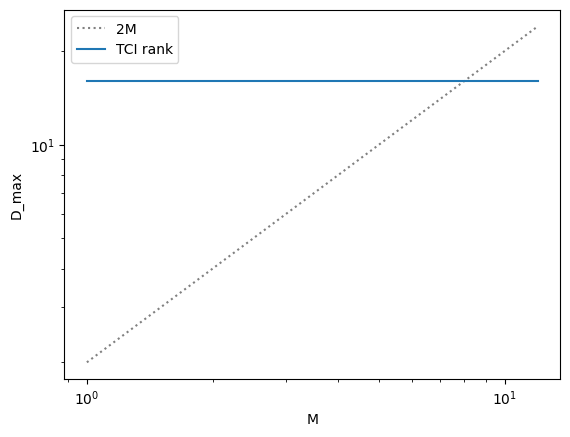

PyObject <matplotlib.legend.Legend object at 0x2b3c52160>

In [105]:
Ms = [r.M for r in results]
loglog(Ms, 2 .* Ms, "gray", linestyle=":", label="2M")
loglog(Ms, [TCI.rank(r.tci) for r in results], label="TCI rank")
xlabel("M")
ylabel("D_max")
legend()